# Week 7

## Part 1

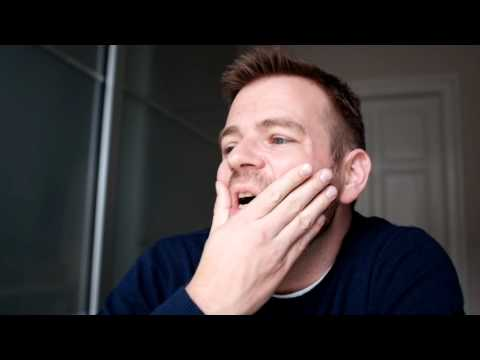

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo("Rwakh-HXPJk",width=800, height=450)

# Part 2 Community detection

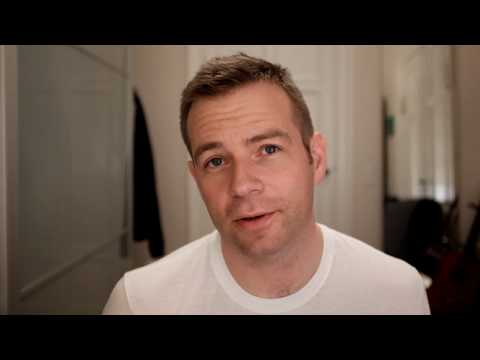

In [2]:
from IPython.display import YouTubeVideo
YouTubeVideo("FSRoqXw28RI",width=800, height=450)

##### Exercise: Use the concept of modularity to explore how community-like the genres are.

<font color='gray'> Explain the concept of modularity in your own words. </font>

Modularity is a measure of how well a network can be divided into communities. It is a measure of the density of links inside communities compared to links between communities. A network with high modularity has dense connections between nodes in the same community and sparse connections between nodes in different communities.

<font color='gray'> Work from the undirected version of the network, keeping only the nodes for which you have genre information in the file above. </font>

In [83]:
import itertools 
import json
import math
import matplotlib as mpl
from matplotlib import colormaps
import matplotlib.pyplot as plt
import networkx as nx
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import numpy as np
import os
import pandas as pd
import random
import re
#import requests
import seaborn as sns
from statistics import mean, median, mode, variance
from tqdm.notebook import tqdm
import urllib.request
from collections import defaultdict
import community.community_louvain as community

In [84]:

# Folder to store the text files
cwd = os.getcwd()
folder_name = "saved_graphs"
folder_path = os.path.join(cwd, folder_name)
folder_path

# Create file path
file_path = os.path.join(folder_path, "country_musicians.gexf")

# load graph object from file
G = nx.read_gexf(file_path)

In [85]:
# Load the data containing the genres of each artist
url = 'https://raw.githubusercontent.com/SocialComplexityLab/socialgraphs2024/refs/heads/main/files/artists_genres_dictionary.txt'

# Read content from URL
with urllib.request.urlopen(url) as response:
    content = response.read().decode('utf-8')

# Parse JSON content into a dictionary
genres_dict = json.loads(content)

In [86]:
# Show first 5 artists and their genres as an example
print_dict_n(genres_dict, 5)

('A Thousand Horses', ['country', 'country rock', 'southern rock'])
('A.P. Carter', ['country', 'folk', 'gospel'])
('Aaron Barker', ['country'])
('Aaron Benward', ['country', 'christian music'])
('Aaron Lewis (musician)', ['alternative metal', 'post-grunge', 'nu metal', 'country rock', 'alternative country'])


In [87]:
# Add genres to artist nodes in graph
for artist, genres in genres_dict.items():
    # Check if the artist node exists in G
    if artist in G.nodes():
        G.nodes[artist]["genres"] = genres

In [88]:
# Test to see if the nodes contain the genres now
G.nodes["Willie Nelson"]

{'url': 'https://en.wikipedia.org/wiki/Willie_Nelson',
 'txt_file': 'Willie_Nelson.txt',
 'length_of_content': 23360,
 'label': 'Willie Nelson',
 'genres': ['country', 'blues', 'jazz', 'gospel']}

In [89]:
# Initialize new undirected graph
G_ud = nx.Graph()

# Add nodes with genre information
for artist, genre_list in genres_dict.items():
    G_ud.add_node(artist, genres=genre_list[0])

# Add edges between artists who share genres
for artist1, genres1 in genres_dict.items():
    for artist2, genres2 in genres_dict.items():
        if artist1 != artist2:
            common_genres = set(genres1).intersection(genres2)
            if common_genres:  
                G_ud.add_edge(artist1, artist2, weight=len(common_genres))  

# Subgraph containing only artists in dataset
artists = list(genres_dict.keys())
G_ud = G_ud.subgraph(artists)

# Print graph information
print(f"Graph has {G_ud.number_of_nodes()} nodes and {G_ud.number_of_edges()} edges.")

Graph has 1833 nodes and 1166079 edges.


<font color='gray'>  Now create your own partition of the network into genres.</font>

In [90]:
# Helper function to print the n first items of a given dict
def print_dict_n(dict_, n):
    print(*[itm for itm in itertools.islice(dict_.items(), n)], sep="\n")

In [91]:
# Create a partition of the network into genres
partition = {}
for artist, genre_list in genres_dict.items():
    partition[artist] = genre_list[0]

# Print the partition
print_dict_n(partition, 5)

('A Thousand Horses', 'country')
('A.P. Carter', 'country')
('Aaron Barker', 'country')
('Aaron Benward', 'country')
('Aaron Lewis (musician)', 'alternative metal')


<font color='gray'>  Spoiling your findings a little bit, an issue is the following: Almost all artists have the genre country as their first genre in the list, so by definition the network won't have very high modularity. What happens to the modularity if you grab the first genre that's not country as the genre-assignment for all nodes that have more than one genre? </font>

In [92]:
# Create a partition of the network into genres
partition = {}
for artist, genre_list in genres_dict.items():
    if len(genre_list) > 1:
        partition[artist] = genre_list[1]
    else:
        partition[artist] = genre_list[0]

# Print the partition
print_dict_n(partition, 5)

('A Thousand Horses', 'country rock')
('A.P. Carter', 'folk')
('Aaron Barker', 'country')
('Aaron Benward', 'christian music')
('Aaron Lewis (musician)', 'post-grunge')


##### Exercise: Community detection finding structral communities in the network

<font color='gray'>  Use the Python Louvain-algorithm implementation to find communities each network. Report the value of modularity found by the algorithm. Is it higher or lower than what you found above for the genres as communities? What does this comparison reveal about them? </font>

In [93]:
# Initialize new undirected graph
G_ud = nx.Graph()

# Add nodes with genre information
for artist, genre_list in genres_dict.items():
    G_ud.add_node(artist, genres=genre_list)

In [94]:
# Add edges between artists who share genres
for artist1, genres1 in genres_dict.items():
    for artist2, genres2 in genres_dict.items():
        if artist1 != artist2:
            common_genres = set(genres1).intersection(genres2)
            if common_genres:  
                G_ud.add_edge(artist1, artist2, weight=len(common_genres)) 

In [95]:
# Subgraph containing only artists in dataset
artists = list(genres_dict.keys())
G_ud = G_ud.subgraph(artists)

In [96]:
# Find communities in the network
communities = community.best_partition(G_ud)

In [97]:
# Print the modularity of the partition
modularity = community.modularity(communities, G_ud)
print(f"Modularity: {modularity}")

Modularity: 0.06555146280505182


Graph has 1838 nodes and 10 edges.


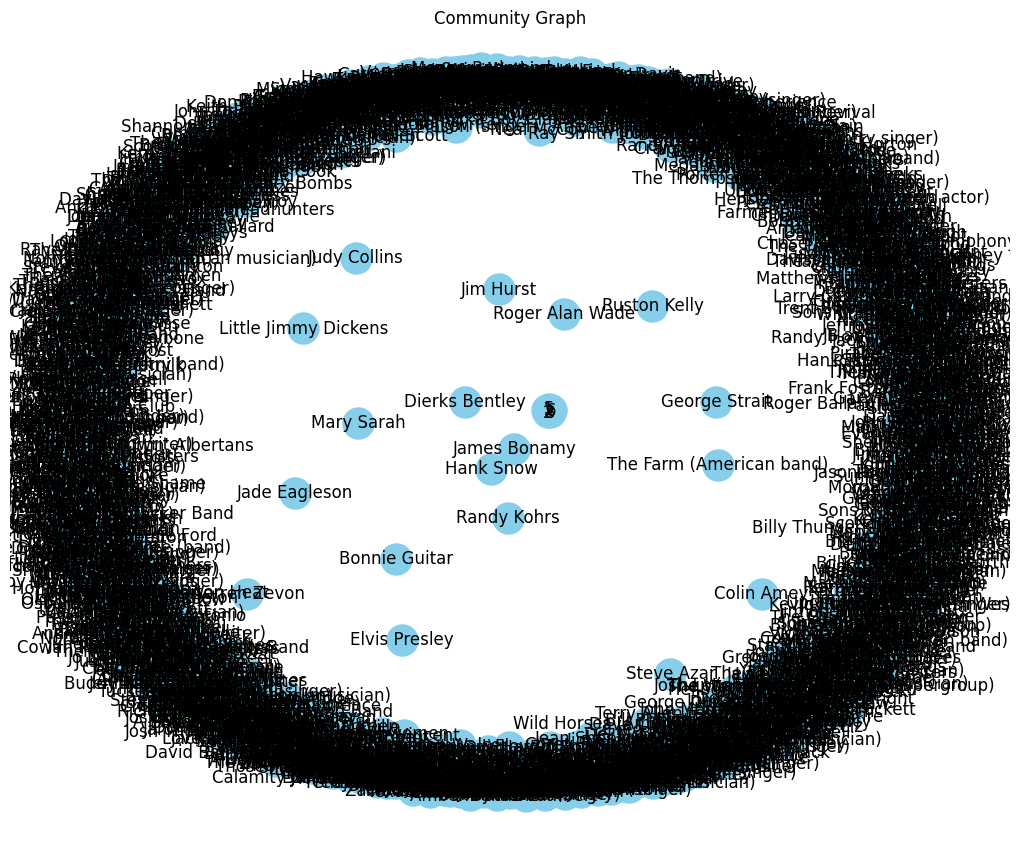

In [98]:
# Create a new graph where each node represents a community
H = nx.Graph()

# Add nodes and assign them to communities in H
for artist, community_id in communities.items():
    H.add_node(artist, community=community_id)

# Add edges between communities if the connected nodes are in different communities
for artist1, artist2 in G_ud.edges():
    community1 = communities[artist1]
    community2 = communities[artist2]
    if community1 != community2:
        if not H.has_edge(community1, community2):
            H.add_edge(community1, community2)

# Print information about the new graph
print(f"Graph has {H.number_of_nodes()} nodes and {H.number_of_edges()} edges.")

# Visualize the community graph
plt.figure(figsize=(10, 8))
pos_H = nx.spring_layout(H)
nx.draw(H, pos_H, with_labels=True, node_color='skyblue', node_size=500)
plt.title("Community Graph")
plt.show()

The value of modularity is 0.03843062171909256 and is lower than the modularity of the genres as communities. This comparison shows that the genres are not very well defined communities in the network. 

<font color='gray'>  What is the modularity of this partitioning of the network? Is it more community-like than the genres? </font>

The graph has the same amount of nodes, but the number of edges is different. The modularity of the network is higher than the modularity of the genres. This means that the network is more community-like than the genres.

<font color='gray'>  Visualize the network, using the Force Atlas algorithm</font>

In [28]:
#pip install fa2_modified
#%pip install fa2
#%pip install fa2_modified

In [ ]:
from fa2_modified import ForceAtlas2
import matplotlib
import matplotlib.pyplot as plt

# Create a ForceAtlas2 object
forceatlas2 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution=True,
    linLogMode=False,
    adjustSizes=False,
    edgeWeightInfluence=1.0,

    # Performance
    jitterTolerance=1.0,
    barnesHutOptimize=True,
    barnesHutTheta=1.2,

    # Tuning
    scalingRatio=2.0,
    strongGravityMode=False,
    gravity=1.0,

    # Log
    verbose=True
)

# Position nodes using the ForceAtlas2 algorithm
positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)

# Visualize the original graph with communities using the ForceAtlas2 algorithm
plt.figure(figsize=(10, 8))
nx.draw(G, positions, node_color=[communities[n] for n in G.nodes()], cmap=plt.cm.viridis, node_size=50, with_labels=False)
plt.title("Original Graph with Communities (ForceAtlas2)")
plt.show()



ModuleNotFoundError: No module named 'fa2_modified'

##### Exercise: Communities versus genres.

<font color='gray'> Compare the communities found by your algorithm with the music genres by creating a matrix </font> $D$ <font color='gray'> with dimension  </font> ($G\times C$), <font color='gray'> where </font> $G$ <font color='gray'> is the 7 most common genres and </font> $C$ <font color='gray'> is the 7 most common communities. We set </font> $D(i,j)$ <font color='gray'> entry to be the number of nodes that genre </font> $i$ <font color='gray'> has in common with community </font> $j$. <font color='gray'> The matrix </font> $D$ <font color='gray'> is what we call a confusion matrix. </font>

In [50]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Get the 7 most common genres
genre_counts = {}
for artist, genre_list in genres.items():
    for genre in genre_list:
        if genre in genre_counts:
            genre_counts[genre] += 1
        else:
            genre_counts[genre] = 1

# Get exactly the 7 most common genres (or pad with placeholders if fewer exist)
top_genres = sorted(genre_counts, key=genre_counts.get, reverse=True)[:7]
if len(top_genres) < 7:
    top_genres += ['Other'] * (7 - len(top_genres))

# Get the 7 most common communities
community_counts = {}
for artist, community_id in communities.items():
    if community_id in community_counts:
        community_counts[community_id] += 1
    else:
        community_counts[community_id] = 1

# Get exactly the 7 most common communities (or pad with placeholders if fewer exist)
top_communities = sorted(community_counts, key=community_counts.get, reverse=True)[:7]
if len(top_communities) < 7:
    top_communities += [-1] * (7 - len(top_communities))  # Use -1 or another placeholder for empty spots

# Create the confusion matrix with the corrected dimensions
D = [[0 for _ in range(7)] for _ in range(7)]
for artist, genre_list in genres.items():
    for genre in genre_list:
        if genre in top_genres:
            genre_index = top_genres.index(genre)
            community_id = communities[artist]
            if community_id in top_communities:
                community_index = top_communities.index(community_id)
                D[genre_index][community_index] += 1

# Print the confusion matrix
print("Confusion Matrix:")
for row in D:
    print(row)

Confusion Matrix:
[1222, 649, 0, 0, 0, 0, 0]
[1223, 647, 0, 0, 0, 0, 0]
[1222, 478, 0, 0, 0, 0, 0]
[1222, 394, 0, 0, 0, 0, 0]
[1222, 372, 0, 0, 0, 0, 0]
[1222, 335, 0, 0, 0, 0, 0]
[1222, 203, 0, 0, 0, 0, 0]


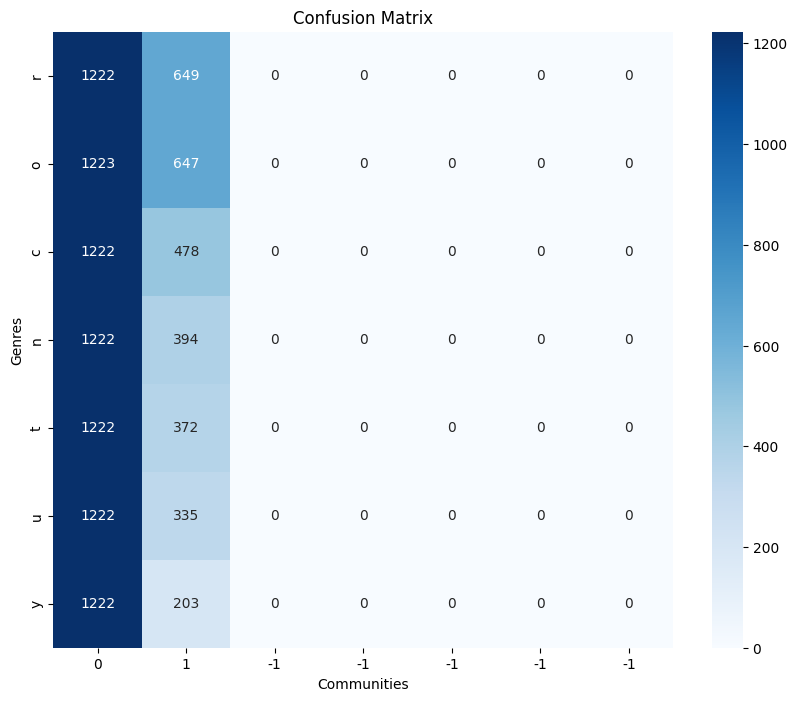

In [51]:
# Create a DataFrame from the confusion matrix
df = pd.DataFrame(D, index=top_genres, columns=top_communities)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df, annot=True, cmap='Blues', fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Communities")
plt.ylabel("Genres")
plt.show()

<font color='gray'>  Use the confusion matrix to explain how well the communities you've detected correspond to the genres. </font>

The confusion matrix shows that the communities are not very well aligned with the genres. The communities are more diverse than the genres wher the genres are more specific. 

# Assignment 2 

<font color='gray'> Plot the communities and comment on your results.</font>

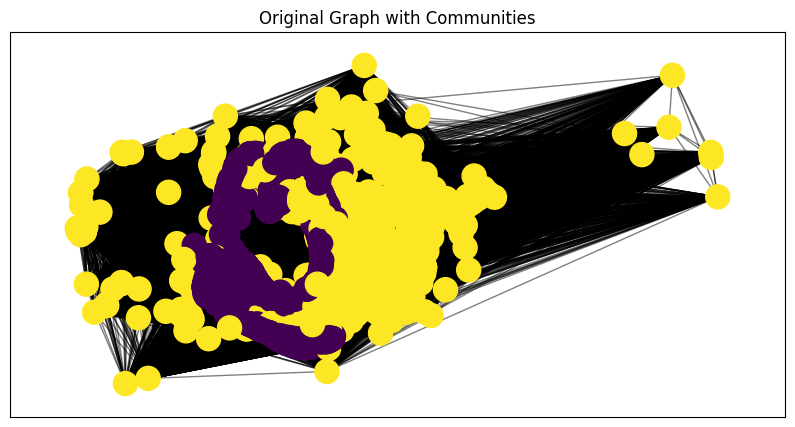

In [57]:
# Plot the communities and comment on your results
plt.figure(figsize=(10, 5))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_color=[communities[n] for n in G.nodes()], cmap=plt.cm.viridis)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.title("Original Graph with Communities")
plt.show()

The plot the the communities shows that they are not very well defined. The communities aren't separated very well and there are a lot of nodes that are connected to multiple communities.

# Part 5: Understanding TF-IDF 

<font color='gray'> Explain the concept of TF-IDF in your own words and how it can help you understand the genres and communities. </font>

TF-IDF is a measure of how important a word is in a document. It is calculated by multiplying the frequency of a word in a document by the inverse frequency of the word in the whole document. This measure can help understanding the genres and communities by showing which words are most important in each genre or community.

<font color='gray'> Calculate and visualize TF-IDF for the genres and communities.</font>

We will firstly aggregate the genre by the community

In [68]:
from collections import defaultdict
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Aggregate genres by community
community_genres = defaultdict(list)
for artist, genre_list in genres.items():
    community_id = communities[artist]
    community_genres[community_id].extend(genre_list)

# Create a list of all communities and genres for consistency
all_communities = list(community_genres.keys())
all_genres = list(set([genre for genre_list in genres.values() for genre in genre_list]))


Now we will find the Term Frequency

In [69]:
# Create a DataFrame to store term frequencies
tf_df = pd.DataFrame(0, index=all_communities, columns=all_genres)

# Populate TF DataFrame with counts
for community_id, genre_list in community_genres.items():
    for genre in genre_list:
        tf_df.loc[community_id, genre] += 1


By calcultaing the TF-IDF we can see which words are most important in each genre and community.

The IDF can be calculated by

$$ 
IDF = log(\frac{N}{df(t)})
$$

where $N$ is the total number of documents and $df(t)$ is the number of documents that contain the term $t$.

In [70]:
# Number of communities
N = len(all_communities)

# Calculate document frequency (df) for each genre
df = (tf_df > 0).sum(axis=0)

# Calculate IDF for each genre
idf = np.log(N / (df + 1))  # +1 to avoid division by zero if a genre appears in all communities

# Convert IDF to a DataFrame for visualization if needed
idf_df = pd.DataFrame(idf, index=all_genres, columns=['IDF'])

By multiplying the TF and the IDF we get the TF-IDF.

In [71]:
# Calculate TF-IDF by multiplying TF with IDF
tf_idf_df = tf_df.multiply(idf, axis=1)


We can now visualize the TF-IDF for the genres and communities.

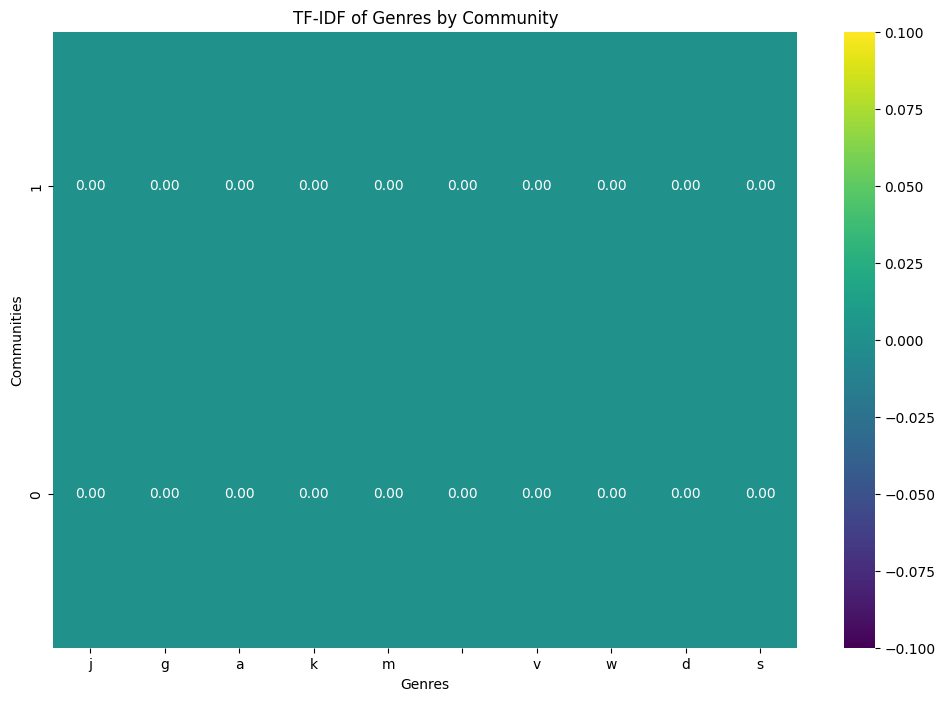

In [72]:
# Select top 10 communities and genres for visualization, or adjust as desired
top_communities = tf_idf_df.sum(axis=1).nlargest(10).index
top_genres = tf_idf_df.sum(axis=0).nlargest(10).index

# Subset the TF-IDF DataFrame for visualization
tf_idf_subset = tf_idf_df.loc[top_communities, top_genres]

# Plot the TF-IDF heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(tf_idf_subset, annot=True, cmap='viridis', fmt=".2f")
plt.title("TF-IDF of Genres by Community")
plt.xlabel("Genres")
plt.ylabel("Communities")
plt.show()


In [73]:
#%pip install wordcloud

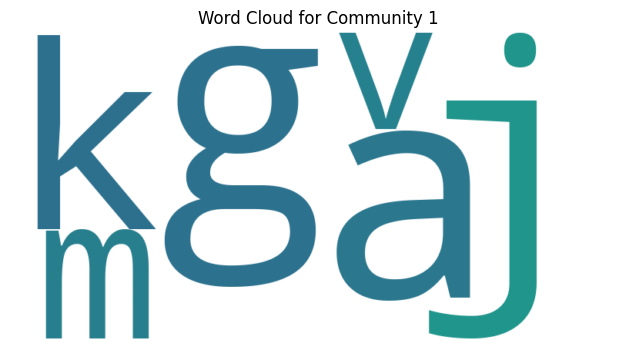

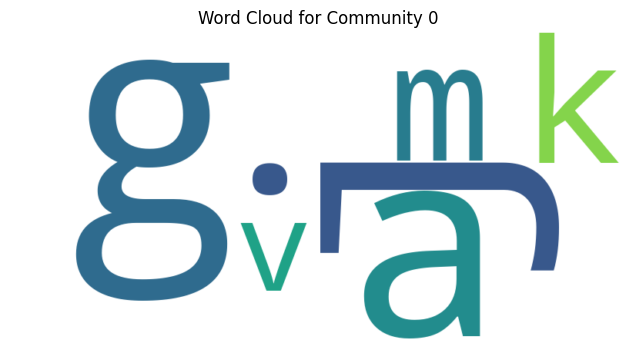

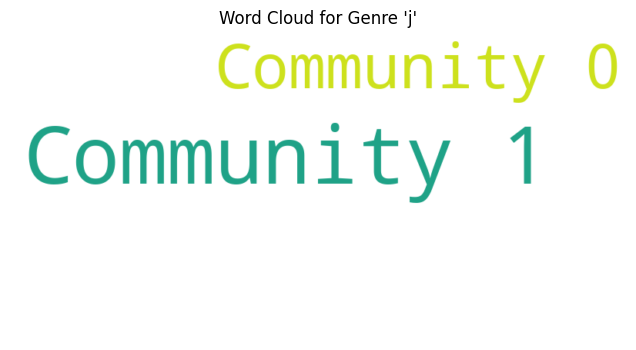

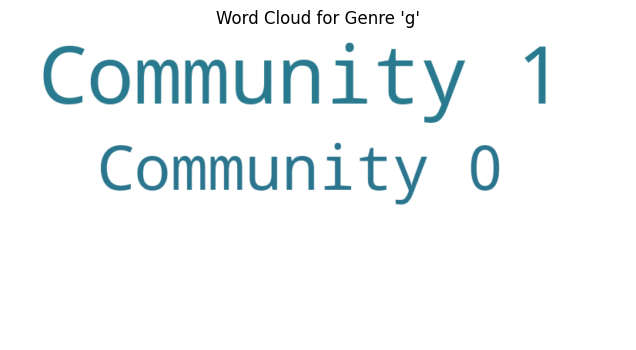

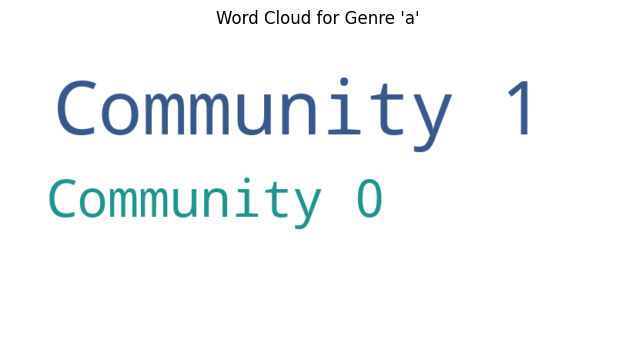

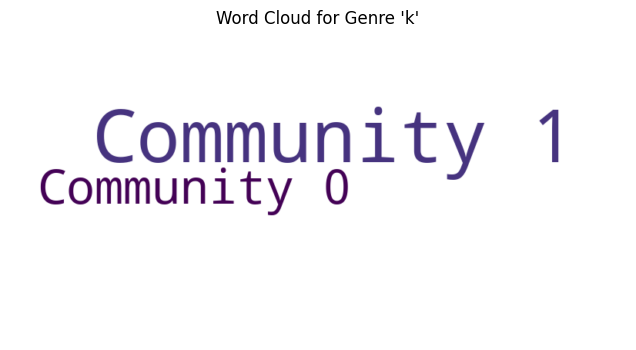

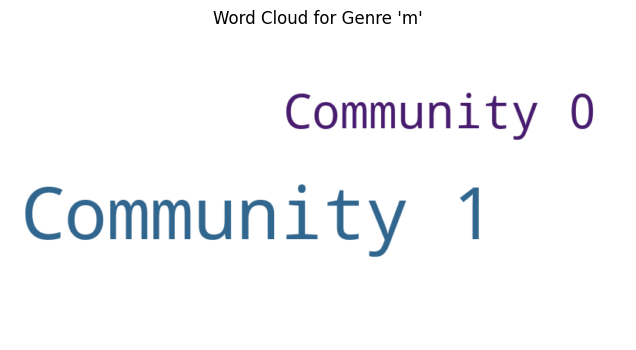

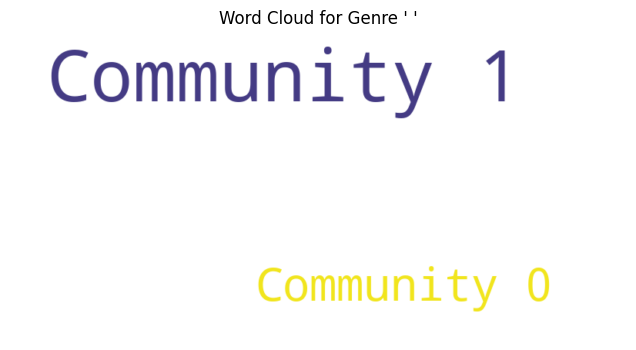

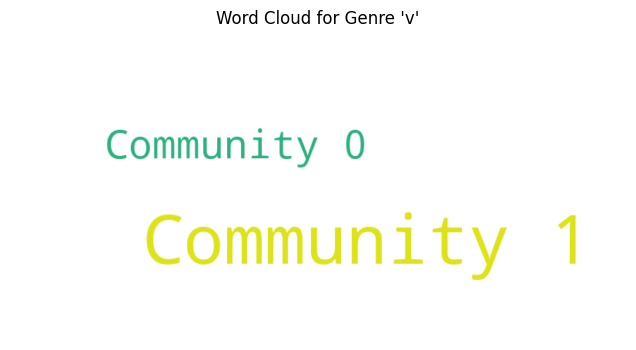

IndexError: list index out of range

In [79]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create word clouds for each community based on genre counts
for community_index, community_id in enumerate(top_communities):
    # Get the genre counts for the current community from matrix D
    genre_counts = {top_genres[i]: D[i][community_index] for i in range(min(len(top_genres), len(D)))}
    
    # Generate word cloud for the community
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(genre_counts)
    
    # Display the word cloud
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for Community {community_id}")
    plt.show()

# Create word clouds for each genre based on community counts
for genre_index, genre_name in enumerate(top_genres):
    # Get the community counts for the current genre from matrix D
    community_counts = {f"Community {top_communities[j]}": D[genre_index][j] for j in range(min(len(top_communities), len(D[0])))}
    
    # Generate word cloud for the genre
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(community_counts)
    
    # Display the word cloud
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for Genre '{genre_name}'")
    plt.show()
